## **Dependencies**

In [1]:
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from tqdm.auto import tqdm
import time
from scipy.spatial.distance import cosine
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

ModuleNotFoundError: No module named 'sentence_transformers'

## **Load Data**

In [2]:
df = pd.read_csv("../../src/merged_orgas.csv")
df.head(3)

,iati_id,iati_orga_id,orga_abbreviation,orga_full_name,client,title_en,title_other,title_main,organization,country_code,...,actual_end,last_update,crs_5_code,crs_5_name,crs_3_code,crs_3_name,docs,title_and_description,sgd_pred_code,sgd_pred_str
0,DE-1-201420207,DE-1,giz,Deutsche Gesellschaft für Internationale Zusam...,BMZ,Environmental and climate governance,Umwelt- und Klimagovernance,Environmental and climate governance,Bundesministerium für wirtschaftliche Zusammen...,['MA'],...,2022-06-30T00:00:00Z,2024-02-29T00:00:00Z,41010;,Environmental policy and administrative manage...,410;,General Environment Protection;,['https://www.giz.de/projektdaten/projects.act...,"Environmental and climate governance. Public, ...",9,"8 Goal 9. Build resilient infrastructure, p..."
1,DE-1-201516970-0,DE-1,bmz,Bundesministerium für wirtschaftliche Zusammen...,BMZ,Acquisition of a chateau d´eau for water stock,Anschaffung eines Wasserturms zur Wasserspeich...,Acquisition of a chateau d´eau for water stock,Bundesministerium für wirtschaftliche Zusammen...,['SN'],...,2022-06-30T00:00:00Z,2024-03-06T00:00:00Z,14030;,Basic drinking water supply and basic sanitati...,140;,Water Supply & Sanitation;,"['https://www.bmz.de/de/laender/senegal', 'htt...",Acquisition of a chateau d´eau for water stock...,6,5 Goal 6. Ensure availability and sustainab...
2,DE-1-201601228-1705,DE-1,bmz,Bundesministerium für wirtschaftliche Zusammen...,BMZ,Multisectoral food and nutrition security for ...,Multisektorale Ernährungssicherung für junge K...,Multisectoral food and nutrition security for ...,Bundesministerium für wirtschaftliche Zusammen...,['MW'],...,2022-06-30T00:00:00Z,2024-03-06T00:00:00Z,31120;,Agricultural development;,311;,Agriculture;,"['https://www.bmz.de/de/laender/malawi', 'http...",Multisectoral food and nutrition security for ...,2,"1 Goal 2. End hunger, achieve food security..."


In [3]:
# slect number of samples
sample_df = df.sample(n=len(df)) #ALL Projects
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54081 entries, 45418 to 43097
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   iati_id                54081 non-null  object
 1   iati_orga_id           54081 non-null  object
 2   orga_abbreviation      54081 non-null  object
 3   orga_full_name         54081 non-null  object
 4   client                 54081 non-null  object
 5   title_en               52929 non-null  object
 6   title_other            44505 non-null  object
 7   title_main             54081 non-null  object
 8   organization           54081 non-null  object
 9   country_code           43060 non-null  object
 10  country                43060 non-null  object
 11  region                 11051 non-null  object
 12  location               34513 non-null  object
 13  description_en         52062 non-null  object
 14  description_other      44281 non-null  object
 15  description_main    

In [4]:
sample_df.columns

Index(['iati_id', 'iati_orga_id', 'orga_abbreviation', 'orga_full_name',
       'client', 'title_en', 'title_other', 'title_main', 'organization',
       'country_code', 'country', 'region', 'location', 'description_en',
       'description_other', 'description_main', 'status', 'planned_start',
       'actual_start', 'planned_end', 'actual_end', 'last_update',
       'crs_5_code', 'crs_5_name', 'crs_3_code', 'crs_3_name', 'docs',
       'title_and_description', 'sgd_pred_code', 'sgd_pred_str'],
      dtype='object')

## **Initiate Model**

### Load Model & Tokenizer

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## **Calculate Embeddings**

### create embeddings data frame

In [6]:
embedding_df = pd.DataFrame()
embedding_df["iati_id"] = sample_df["iati_id"]
embedding_df["embedding"] = list

embedding_df.head(3)

,iati_id,embedding
34612,XM-DAC-46004-49227-003-LN3362,<class 'list'>
7490,DE-1-201134063-0,<class 'list'>
30888,DE-1-201576701-0,<class 'list'>


### calculate embeddings for all descriptions

In [7]:
# Function to get embeddings
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)

    return outputs.pooler_output.squeeze().detach().numpy()

In [8]:
for index, row in tqdm(sample_df.iterrows(), total=sample_df.shape[0]):
    try:
        embedding_df.at[index, "embedding"] = get_embedding(row["title_and_description"])
    except Exception as e:
        print(f"Error processing index {index}: {e}")


100%|██████████| 54081/54081 [3:33:37<00:00,  4.22it/s]  


In [9]:
embedding_df.head(3)

,iati_id,embedding
34612,XM-DAC-46004-49227-003-LN3362,"[-0.6430101, -0.76168305, -0.9996717, 0.862266..."
7490,DE-1-201134063-0,"[-0.745798, -0.72188354, -0.99842364, 0.851809..."
30888,DE-1-201576701-0,"[-0.84510195, -0.53723425, -0.9963881, 0.87295..."


### export embeddings as csv

In [10]:
embedding_df.to_csv("../../src/transformer/embedding.csv", index=False) 

## **Calculate Similarities**

### read in embeddings if not done all in one step

In [8]:
embedding_df = pd.read_csv("../../src/transformer/embedding.csv")
embedding_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54081 entries, 0 to 54080
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   iati_id    54081 non-null  object
 1   embedding  54081 non-null  object
dtypes: object(2)
memory usage: 845.1+ KB


### remove duplicates rows

In [9]:
embedding_df = embedding_df.drop_duplicates(keep="first")

In [10]:
len(embedding_df)

47036

### convert string from csv into np array

In [11]:
embedding_df['embedding'] = embedding_df['embedding'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))

In [13]:
embedding_df.head(2)

,iati_id,embedding
0,XM-DAC-46004-49227-003-LN3362,"[-0.6430101, -0.76168305, -0.9996717, 0.862266..."
1,DE-1-201134063-0,"[-0.745798, -0.72188354, -0.99842364, 0.851809..."


### estimate calculation time

c:\Users\UserNA6153\anaconda3\envs\pamb\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Measured times: [0.015554428100585938, 0.10476088523864746, 0.43425846099853516]
Estimated time for the full dataset: 1068.56 seconds


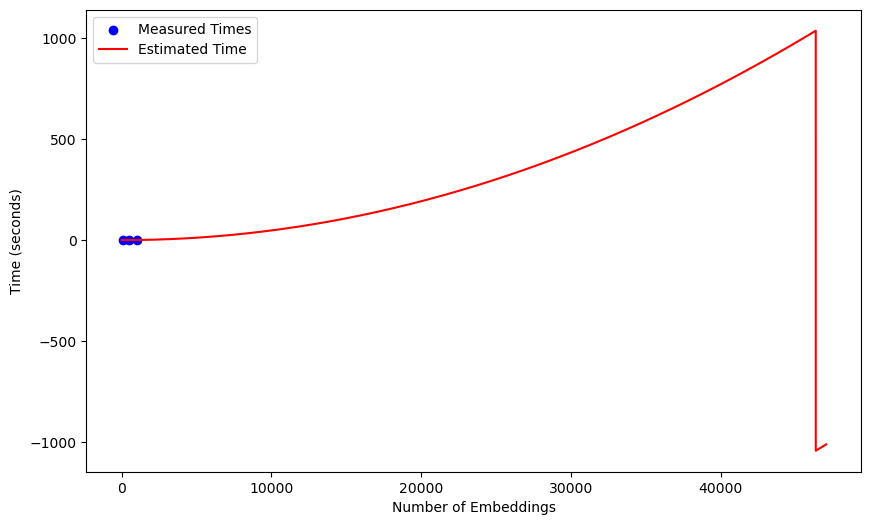

In [14]:
embeddings = np.stack(embedding_df['embedding'].values)

def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c

n_samples = [100, 500, 1000]
times = []
np.random.seed(42) 

for n in n_samples:
    start_time = time.time()
    _ = 1 - squareform(pdist(embeddings[:n], metric='cosine'))
    times.append(time.time() - start_time)

# Fit the quadratic model to your benchmark data
params, _ = curve_fit(quadratic_model, n_samples, times)

# Use the model to estimate the time for the full dataset
n_full = len(embeddings)
estimated_time_full = quadratic_model(n_full, *params)
print(f"Measured times: {times}")
print(f"Estimated time for the full dataset: {estimated_time_full:.2f} seconds")

# Plotting the estimation curve
plt.figure(figsize=(10, 6))
plt.scatter(n_samples, times, color='blue', label='Measured Times')
plt.plot(range(1, n_full+1), quadratic_model(np.array(range(1, n_full+1)), *params), color='red', label='Estimated Time')
plt.xlabel('Number of Embeddings')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()


### embeddings as float32 instead of float64 to save storage

In [15]:
embeddings = np.stack(embedding_df['embedding'].values).astype(np.float32)

### calculate matrix

In [16]:
# Calculate pairwise cosine similarities
# Note: `pdist` calculates distance, and cosine similarity is 1 - cosine distance (cosine similarity is the complement of cosine distance)
similarity_matrix = 1 - squareform(pdist(embeddings, metric='cosine'))
print("Finished calculating similarity matrix")

np.fill_diagonal(similarity_matrix, 0)
print("Set diagonal to 0")

similarity_df = pd.DataFrame(similarity_matrix, columns=embedding_df['iati_id'], index=embedding_df['iati_id'])
print("Saved similarity matrix to df")

### export simiolarity matrix as csv

In [11]:
similarity_df.to_csv("../../src/transformer/similarities.csv", index=False) 

In [7]:
similarity_df = pd.read_csv("../../src/transformer/similarities.csv")

MemoryError: 

In [ ]:
similarity_df.head(40000)

iati_id,XM-DAC-46004-49227-003-LN3362,DE-1-201134063-0,DE-1-201576701-0,XI-IATI-IADB-BR-L1539,XM-DAC-918-3-20160453-86438,XM-DAC-5-7-6613628,XM-DAC-5-7-6610400,DE-1-201233402-0,46002-P-TZ-IBD-002,DE-1-201479922-0,...,DE-1-202050904-0,DE-1-201531029-0,DE-1-200970244,XM-DAC-918-3-20160523-86573,DE-1-201640481,DE-1-202134864-0,DE-1-201232503-0,46002-P-MU-DB0-004,44000-P078971,DE-1-200721944
iati_id,,,,,,,,,,,,,,,,,,,,,
XM-DAC-46004-49227-003-LN3362,1.000000,0.964353,0.961550,0.970175,0.957624,0.986182,0.945390,0.986013,0.935133,0.917294,...,0.969502,0.959010,0.972279,0.929038,0.984730,0.970741,0.825249,0.911028,0.941813,0.980021
DE-1-201134063-0,0.964353,1.000000,0.977891,0.982261,0.968652,0.982926,0.975701,0.981887,0.958593,0.928527,...,0.979811,0.963516,0.920935,0.965328,0.966178,0.966286,0.871650,0.953155,0.964422,0.986718
DE-1-201576701-0,0.961550,0.977891,1.000000,0.962109,0.989830,0.981766,0.969966,0.970920,0.922277,0.972192,...,0.970424,0.945317,0.949781,0.960254,0.978683,0.985540,0.833382,0.954760,0.930853,0.965021
XI-IATI-IADB-BR-L1539,0.970175,0.982261,0.962109,1.000000,0.957768,0.984443,0.971458,0.984518,0.969914,0.918479,...,0.986194,0.976820,0.917929,0.962026,0.959487,0.965674,0.902769,0.956683,0.976605,0.989287
XM-DAC-918-3-20160453-86438,0.957624,0.968652,0.989830,0.957768,1.000000,0.978422,0.971003,0.966617,0.919254,0.979841,...,0.968028,0.936136,0.944954,0.971494,0.974020,0.984779,0.827645,0.960891,0.924150,0.958227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46002-P-ET-AAE-008,0.960947,0.974133,0.989848,0.968810,0.994234,0.981141,0.981345,0.970372,0.937795,0.973921,...,0.978639,0.942378,0.936472,0.978252,0.970182,0.987370,0.852662,0.971380,0.941831,0.966716
46002-P-CV-KA0-009,0.840962,0.872090,0.802151,0.898199,0.795798,0.847441,0.878633,0.866947,0.955013,0.719732,...,0.884535,0.881804,0.723600,0.866811,0.791594,0.804399,0.902570,0.857097,0.947912,0.887463
DE-1-201970581,0.971538,0.974843,0.991286,0.967261,0.990231,0.985968,0.965099,0.975086,0.926600,0.970085,...,0.971063,0.946986,0.960098,0.959759,0.985318,0.986838,0.835184,0.950556,0.933963,0.969687


In [ ]:
similarity_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54081 entries, XM-DAC-46004-49227-003-LN3362 to DE-1-200721944
Columns: 54081 entries, XM-DAC-46004-49227-003-LN3362 to DE-1-200721944
dtypes: float64(54081)
memory usage: 21.8+ GB


### change to float 32

In [ ]:
similarity_float32_df = similarity_df.astype('float32')

In [ ]:
similarity_float32_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54081 entries, XM-DAC-46004-49227-003-LN3362 to DE-1-200721944
Columns: 54081 entries, XM-DAC-46004-49227-003-LN3362 to DE-1-200721944
dtypes: float32(54081)
memory usage: 10.9+ GB


In [ ]:
similarity_float32_df.head(2)

iati_id,XM-DAC-46004-49227-003-LN3362,DE-1-201134063-0,DE-1-201576701-0,XI-IATI-IADB-BR-L1539,XM-DAC-918-3-20160453-86438,XM-DAC-5-7-6613628,XM-DAC-5-7-6610400,DE-1-201233402-0,46002-P-TZ-IBD-002,DE-1-201479922-0,...,DE-1-202050904-0,DE-1-201531029-0,DE-1-200970244,XM-DAC-918-3-20160523-86573,DE-1-201640481,DE-1-202134864-0,DE-1-201232503-0,46002-P-MU-DB0-004,44000-P078971,DE-1-200721944
iati_id,,,,,,,,,,,,,,,,,,,,,
XM-DAC-46004-49227-003-LN3362,1.000000,0.964353,0.961550,0.970175,0.957624,0.986182,0.945390,0.986013,0.935133,0.917294,...,0.969502,0.959010,0.972279,0.929038,0.984730,0.970741,0.825249,0.911028,0.941813,0.980021
DE-1-201134063-0,0.964353,1.000000,0.977891,0.982261,0.968652,0.982926,0.975701,0.981887,0.958593,0.928527,...,0.979811,0.963516,0.920935,0.965328,0.966178,0.966286,0.871650,0.953155,0.964422,0.986718


### change to sparse matrix

In [ ]:
#similarity_sparse_df = similarity_float32_df.astype(pd.SparseDtype("float", 0))

In [ ]:
#similarity_sparse_df.info()

In [ ]:
#similarity_sparse_df.head(2)

### remove duplicates

In [ ]:
duplicate_rows = similarity_float32_df.duplicated()
duplicate_cols = similarity_float32_df.T.duplicated()

# Remove duplicates
filtered_matrix = similarity_float32_df.loc[~duplicate_rows, ~duplicate_cols]

NameError: name 'similarity_float32_df' is not defined

In [ ]:
filtered_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41892 entries, XM-DAC-46004-49227-003-LN3362 to DE-1-200721944
Columns: 41892 entries, XM-DAC-46004-49227-003-LN3362 to DE-1-200721944
dtypes: float16(41892)
memory usage: 3.3+ GB


### save in parquet format

In [ ]:
filtered_matrix.to_parquet('../../src/transformer/similarities.parquet', compression='gzip')

ArrowNotImplementedError: Unhandled type for Arrow to Parquet schema conversion: halffloat

### export similarities as csv

In [ ]:
similarity_df.to_csv("../../src/transformer/similarities.csv", index=False) 